# First optimization problem using NRV

---
In this tutorial, the optimization formalism used in NRV is illustrated through a detailed example.

The very first step is, as usual, to import NRV and the required packages and to generate an outputs' repository.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append("../")
import nrv

test_name = "Tutorial_5"
dir_res = f"./{test_name}/"
if not os.path.isdir(dir_res):
    os.mkdir(dir_res)



## Principle

In NRV, an optimization problem is composed of two components, as illustrated by the figure below: 
 - **An optimizer** : based on third party libraries (``scipy`` and ``pyswarms``) algorithms.
 - **A cost function**: a function from $\real^n$ to $\real$ that should be minimized.


In addition, NRV introduces a way to evaluate the impact of specific parameters in simulations and final cost assessment through a `Cost_Function`-class consisting in:

 - A filter: an optional Python `callable`-object for vector formatting or space restriction.
 - A static context: the initial point of the simulation, often a NRV-nmod object like axon, fascicle, or nerve, with a `simulate`-method.
 - A `ContextModifier`-object: creates an updated local context from the static context and input vector.
 - A `CostEvaluation`-object: evaluates a cost from simulation results. It's a generic Python `callable`-class, allowing user-defined functions.





![alt text](../docs/images/optim.png)


## First optimization: Pulse Stimulus on Single axon

The objective of the first optimization problem is to **minimize a pulse stimulus energy required by a LIFE-electrode to trigger a single myelinated fibre**.

### Cost function

To begin, we can create an empty cost function object and fill it progressively with its components.

In [2]:
## Cost function definition
costfname0 = dir_res + "/energy_cost_biphasic.csv"

my_cost0 = nrv.CostFunction()

#### Static context

The first step to implement the optimization is to define the static context. This context can be generated with the following script, the same way as in previous examples (XXX). 
In this first example the context is only composed of:

 - a myelinated axon: $10mm$ long, $10\mu m$ diameter large, with a centre located at $(y=50\mu m, z=0)$
 - a LIFE-electrode: $1mm$ long, $25\mu m$ diameter large, with a centre located at $(x=5000\mu m, y=0, z=0)$

---
**NOTES:**

  -  As the stimulus of the LIFE-electrode will be regenerated during the optimization a *dummy stimulus* is associated to the electrode

  - To speed up the simulations done later, in the optimization, the footprints of the electrode on the axon are computed with `get_electrodes_footprints_on_axon` method and save with the context.
---

Once generated, the axon and its extracellular context can be saved in a `.json` file with using NRV `save` methods (XXX). This file will be loaded by the `cost_function` every times it will be called for the optimization.



NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 11349
NRV INFO: Number of elements : 80749
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 4.045804023742676 s


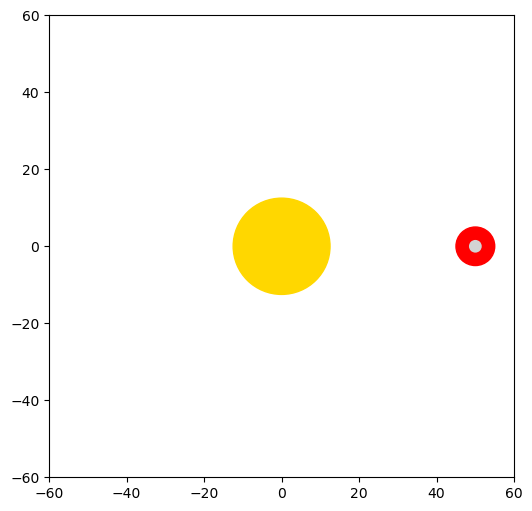

In [3]:
axon_file = dir_res + "myelinated_axon.json"

ax_l = 10000 # um
ax_d=10
ax_y=50
ax_z=0
axon_1 = nrv.myelinated(L=ax_l, d=ax_d, y=ax_y, z=ax_z)


LIFE_stim0 = nrv.FEM_stimulation()
LIFE_stim0.reshape_nerve(Length=ax_l)
life_d = 25 # um
life_length = 1000 # um
life_x_0_offset = (ax_l-life_length)/2
life_y_c_0 = 0
life_z_c_0 = 0
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

dummy_stim = nrv.stimulus()
dummy_stim.pulse(0, 0.1, 1)
LIFE_stim0.add_electrode(elec_0, dummy_stim)

axon_1.attach_extracellular_stimulation(LIFE_stim0)
axon_1.get_electrodes_footprints_on_axon()
_ = axon_1.save(save=True, fname=axon_file, extracel_context=True)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
axon_1.plot(ax)
ax.set_xlim((-1.2*ax_y, 1.2*ax_y))
ax.set_ylim((-1.2*ax_y, 1.2*ax_y))

del axon_1

Once this static context has been saved in the cost function it should be linked with the `cost_function`.

For that purpose, we can use the method `set_static_context` as bellow. 

Note that additional keys arguments can be added to precise simulation parameter. 
Here we impose a simulation time of $5ms$ and a time step of $5\mu s$. These arguments will be added when the `simulate` method will be called so all the parameters of a standard simulation can be as in previous example

In [4]:
static_context = axon_file
t_sim = 5
dt = 0.005
kwarg_sim = {
    "dt":dt,
    "t_sim":t_sim,
}

my_cost0.set_static_context(axon_file, **kwarg_sim)

#### Context modifier

The next step is to define how to interpret the tuning parameters to modify the static context. In our problem, we want to modify the LIFE-electrode's stimulus shape and evaluate its impact on the fiber. There are countless ways to define a waveform from a set of points, so let's consider a very simple method:

  $-$ The stimulus is a cathodic conventional square pulse. In this scenario, both the pulse duration $T_{sq}$ and pulse amplitude $I_{sq}$ can be optimized, resulting in a two-dimensional optimization problem. The tuning parameters input vector $\mathcal{X}_{sq}$ of the optimization problem is thus defined as follows:
$$
\mathcal{X}_{sq} = \begin{pmatrix} I_{sq} & T_{sq} \end{pmatrix} \;
$$

#### **Implementation:**

In NRV, the modification of the static context can either be done with a callable class or a function. Some `context_modifier` classes have already been implemented in NRV.

The `biphasic_stimulus_CM` is appropriate for our problem. Such `context_modifier`(XXX) add a biphasic pulse to a given electrode of a `nrv_simulable` object. 
To fit with our problem, we set the following arguments:
 - `start=1`: the cathodic pulse to start at $1ms$.
 - `I_cathod="0"` the cathodic pulse amplitude is defined by the first value of the input vector $\mathcal{X}_{sq}$.
 - `T_cathod="1"` the cathodic pulse duration is defined by the second value of the input vector $\mathcal{X}_{sq}$.
 - `I_anod=0` anodic pulse amplitude is 0 (we consider a monophasic pulse).

---
**NOTE**

Arguments of `biphasic_stimulus_CM` are similar to those of `stimulus.biphasic_pulse` (XXX). User can either set the argument to a specific value or specify that it should be defined by a tuning parameters input vector. In the second case the argument should be a `str` of the index of the argument in the vector.

---

In [5]:
t_start = 1
I_max_abs = 100

cm_0 = nrv.biphasic_stimulus_CM(start=t_start, I_cathod="0", T_cathod="1", I_anod=0)
my_cost0.set_context_modifier(cm_0)

The following lines illustrate the stimuli generated by the `cm_0` for various input parameters.

As expected:
 - The first dimension of fix the negative amplitude of the pulse.
 - The second the duration the pulse.

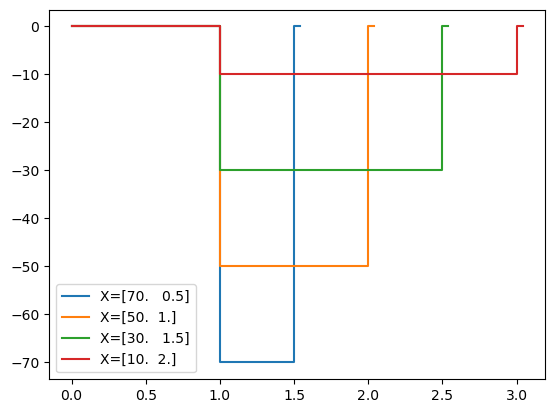

In [6]:
test_points = np.array([[70, 0.5], [50, 1], [30, 1.5], [10, 2]])

fig, ax = plt.subplots()
for X in test_points:
    axon_x = cm_0(X, static_context)
    stim = axon_x.extra_stim.stimuli[0]
    stim.plot(ax, label=f"X={X}")
    ax.legend()
    del axon_x

#### Cost Evaluation

In our problem, we want at the same time to minimize the energy of the stimulus and maximize the number of fibre recruited. Therefore, we can evaluate the *cost* of a stimulus on the context using the following equation:
$$
    Cost = \alpha_e\sum_{t_k}{i_{stim}^2(t_k)}+\alpha_r(N_{axon}-N_{recruited})
$$

With:
 - $t_k$ as the discrete time step of the simulation.
 - $N_{axon}$ as the number of axon simulated, 1 in this first problem.
 - $N_{recruited}$ as the number of fibre triggered by the stimulation.
 - $\alpha_e$ and $\alpha_r$ as two weighting coefficients.


**Implementation:**

In NRV, the computation of this cost from simulation results is handled by a function or a callable class instance called `cost_evaluation`. As for `context_modifier`, several `cost_evaluation` classes are already implemented in the NRV package. These classes can be combined with algebraic operations to easily generate more complex cases.

Here, the cost evaluation is generated using two classes implemented in NRV:
 1. `recrutement_count_CE`: computes the number of triggered fibres.

 2. `stim_energy_CE`: computes a value proportional to the stimulus energy.

---
**NOTES:**

 - The second term of the equation ($\alpha_r(N_{axon} - N_{recruited})$) essentially represents a function that is 1 if the fibre is triggered and 0 otherwise. This seemingly complicated notation allows us to use the same equation to evaluate a stimulus in contexts involving a larger number of axons.

 - With a good knowledge of the simulation results, it is possible to implement custom `cost_evaluation`, similar to `context_modifier`.
  It should be a function or a callable class taking a `sim_results` object and any additional `kwargs` parameters, returning a corresponding cost (`float`).

---

In [7]:
costR = nrv.recrutement_count_CE(reverse=True)
costC = nrv.stim_energy_CE()

cost_evaluation = costR + 0.01 * costC
my_cost0.set_cost_evaluation(cost_evaluation)

## Optimization problem

At this point, the cost function which should be minimized is fully defined.
We can now start to define the whole optimization by setting the right optimizer.

The cost_function define for the problem is not continuous because of the second term of the cost evaluation equation ($\alpha_r(N_{axon} - N_{recruited})$). Therefore, a metaheuristic is more suitable for our problem.

For now, the only metaheuristic implemented in NRV is the PSO based on the module [Pyswarms](https://pyswarms.readthedocs.io/en/latest/). 

In [18]:
pso_kwargs = {
    "maxiter" : 20,
    "n_particles" : 20,
    "opt_type" : "local",
    "options": {'c1': 0.45, 'c2': 0.45, 'w': 0.75, 'k': 5, 'p': 1},
    "bh_strategy": "reflective",
}
pso_opt = nrv.PSO_optimizer(**pso_kwargs)

In [8]:
# Problem definition
fname0 = dir_res + "/energy_optim_pso_biphasic.json"
my_prob = nrv.Problem(save_problem_results=False)
my_prob.optimizer = pso_opt


t_end = 0.5
duration_bound = (0.01, t_end)
bounds0 = (
    (0, I_max_abs),
    duration_bound
)
pso_kwargs0 = {
    "maxiter" : 20,
    "n_particles" : 20,
    "dimensions" : 2,
    "opt_type" : "local",
    "options": {'c1': 0.45, 'c2': 0.45, 'w': 0.75, 'k': 5, 'p': 1},
    "bh_strategy": "reflective",
    "bounds" : bounds0,
    "comment":"pulse"}


my_prob.costfunction = my_cost0
res0 = my_prob(problem_fname=fname0, **pso_kwargs0)


pyswarms.single.general_optimizer: 100%|██████████|20/20, best_cost=0.0495


Optimization results are saved in `nrv_result` class. Therefore, all results can either be access as `dictionary` keys or as attributes.



((0, 100), (0.01, 0.5)) [8.389865991263383, 0.07034935343766316]


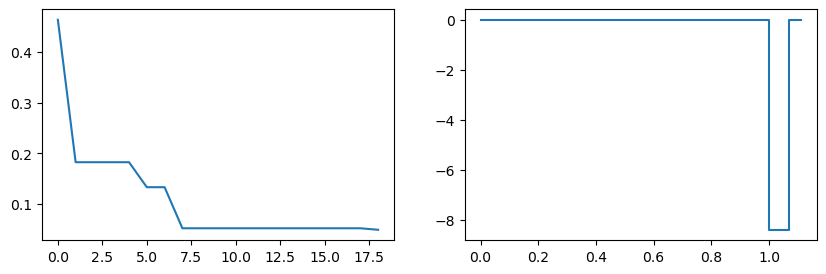

In [9]:
fig_costs, axs_costs = plt.subplots(1, 2, figsize=(10, 3))
res0.plot_cost_history(axs_costs[0])
stim = cm_0(res0.x, static_context).extra_stim.stimuli[0]

stim.plot(axs_costs[1])

print(bounds0, res0.x)


<class 'nrv.nmod.results.myelinated_results.myelinated_results'>


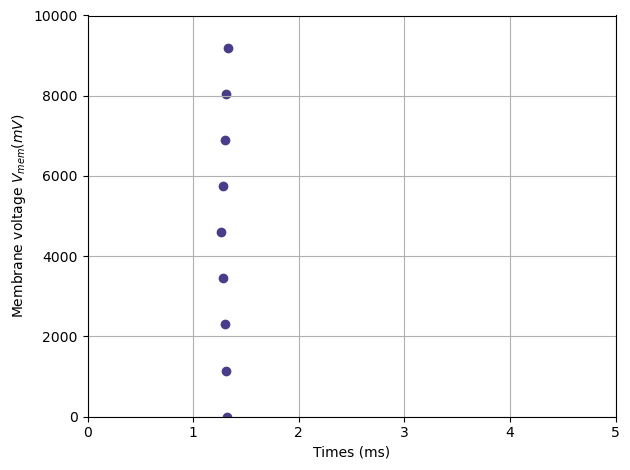

In [17]:
simres = res0.compute_best_pos(my_cost0)
nrv.rasterize(simres, "V_mem")
plt.figure()
plt.scatter(simres["V_mem_raster_time"], simres["V_mem_raster_x_position"],color = 'darkslateblue')
plt.xlabel('Times (ms)')
plt.ylabel('Membrane voltage $V_{mem} (mV)$')
plt.xlim(0, t_sim)
plt.ylim(0, simres["L"])
plt.grid()
plt.tight_layout()

## Second optimization

2. The stimulation is defined as an arbitrary cathodic pulse through interpolated splines over $2$ points which are individually defined in time and amplitude. This second optimization scenario results in a $4$-dimensional problem with the input vector $\mathcal{X}_{s_2}$ defined as follow: 
$$
\mathcal{X}_{s_2} = \begin{pmatrix} I_{s_1} & t_{s_1} & I_{s_2} & t_{s_2}    \end{pmatrix}
$$

In [ ]:
t_sim = 5
I_bound = (-I_max_abs, 0)
t_bound = (0, t_end)


kwrgs_interp = {
    "dt": dt,
    "amp_start": 0,
    "amp_stop": 0,
    "intertype": "Spline",
    "bounds": I_bound,
    "t_sim":t_sim,
    "t_end": t_end,
    "t_shift": t_start,
    }
cm_1 = nrv.stimulus_CM(interpolator=nrv.interpolate_Npts, intrep_kwargs=kwrgs_interp, t_sim=t_sim)

In [ ]:
test_points = np.array([[-10, 1, ], [50, 1]])

fig, ax = plt.subplots()
for X in test_points:
    axon_x = cm_0(X, static_context)
    stim = axon_x.extra_stim.stimuli[0]
    stim.plot(ax, label=f"X={X}")
    ax.legend()
    del axon_x

This time all the components of the new `cost_function` are already defined. It can thus be directly defined at the initialization as bellow.

In [ ]:
my_cost_1 = nrv.CostFunction(
    static_context=static_context,
    context_modifier=cm_1,
    cost_evaluation=cost_evaluation,
    kwargs_S=kwarg_sim,
    t_sim=t_sim,
    file_name=costfname0)

In [ ]:
bounds1 = (t_bound, I_bound, t_bound, I_bound)

pso_kwargs2 = {
    "n_particles" : 20,
    "bounds" : bounds1,
    "dimensions" : 4,
    "maxiter" : 50,
    "opt_type" : "local",
    "options": {'c1': 0.5, 'c2': 0.5, 'w': 0.75, 'k': 5, 'p': 1},
    "bh_strategy": "reflective",
    "comment":"spline 2pt"}

my_prob.costfunction = my_cost_1
res1 = my_prob(problem_fname=fname0, **pso_kwargs2)

In [ ]:
res1.plot_cost_history(axs_costs[0])
stim = cm_1(res1.x, static_context).extra_stim.stimuli[0]

stim.plot(axs_costs[1])

print(bounds1, res1.x)

fig_costs


---

In [ ]:
# nerve_file = dir_res + "nerve.json"

# outer_d = 5 # mm
# nerve_d = 300 # um
# nerve_l = 10000 # um

# fasc1_d = 250 # um
# fasc1_y = 0
# fasc1_z = 0
# n_ax1 = 100


# nerve_1 = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d)

# axons_diameters, axons_type, M_diam_list, U_diam_list = nrv.create_axon_population(n_ax1, percent_unmyel=0, M_stat="Ochoa_M", U_stat="Ochoa_U",)

# fascicle_1 = nrv.fascicle(ID=0)      #we can add diameter here / no need to call define_circular_contour (not tested)
# fascicle_1.define_circular_contour(fasc1_d)
# fascicle_1.fill_with_population(axons_diameters, axons_type, fit_to_size=True,delta=5)
# fascicle_1.generate_random_NoR_position()
# nerve_1.add_fascicle(fascicle=fascicle_1, y=fasc1_y, z=fasc1_z)

# # LIFE in neither of the two fascicles
# LIFE_stim0 = nrv.FEM_stimulation()
# life_x_0_offset = (nerve_l-life_length)/2
# elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

# stim0 = nrv.stimulus()
# stim0.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)
# LIFE_stim0.add_electrode(elec_0, stim0)
# nerve_1.attach_extracellular_stimulation(LIFE_stim0)

# fig, ax = plt.subplots(1, 1, figsize=(6,6))
# nerve_1.plot(ax)

# nerve_1.compute_electrodes_footprints()
# nerve_1.set_parameters(postproc_script="is_excited")
# _ = nerve_1.save(fname=nerve_file, extracel_context=True)